# Hourly clustering over whole year 2024

In [ ]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation

## Data extraction and preprocessing

In [ ]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess(df):
    # Parse the timestamp column (assuming 'timestamp' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    
    return day_avg

def normalize(df):  
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    time_avg = day_avg_preprocess(df)
    time_avg_norm = normalize(time_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    time_avg_norm.write_csv(output_file)

## Data Clustering

In [ ]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [150]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d


Shape of the 3D array: (1464, 96, 1)


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

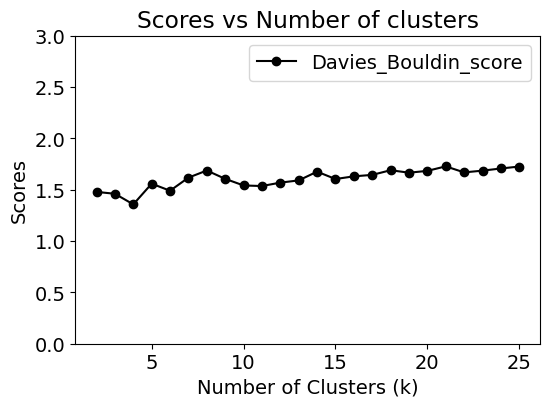

In [152]:
validation(train_data)

# K-means Clustering
change n_clusters as required

In [154]:



n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

3.307 --> 2.368 --> 2.238 --> 2.192 --> 2.178 --> 2.175 --> 2.174 --> 2.173 --> 2.172 --> 2.172 --> 2.171 --> 2.170 --> 2.169 --> 2.168 --> 2.167 --> 2.166 --> 2.165 --> 2.164 --> 2.162 --> 2.160 --> 2.157 --> 2.156 --> 2.155 --> 2.155 --> 2.154 --> 2.154 --> 2.154 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 


# Plotting the cluster average patterns

In [157]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season(save):
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("daily_profiles, normalized for each household separately", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

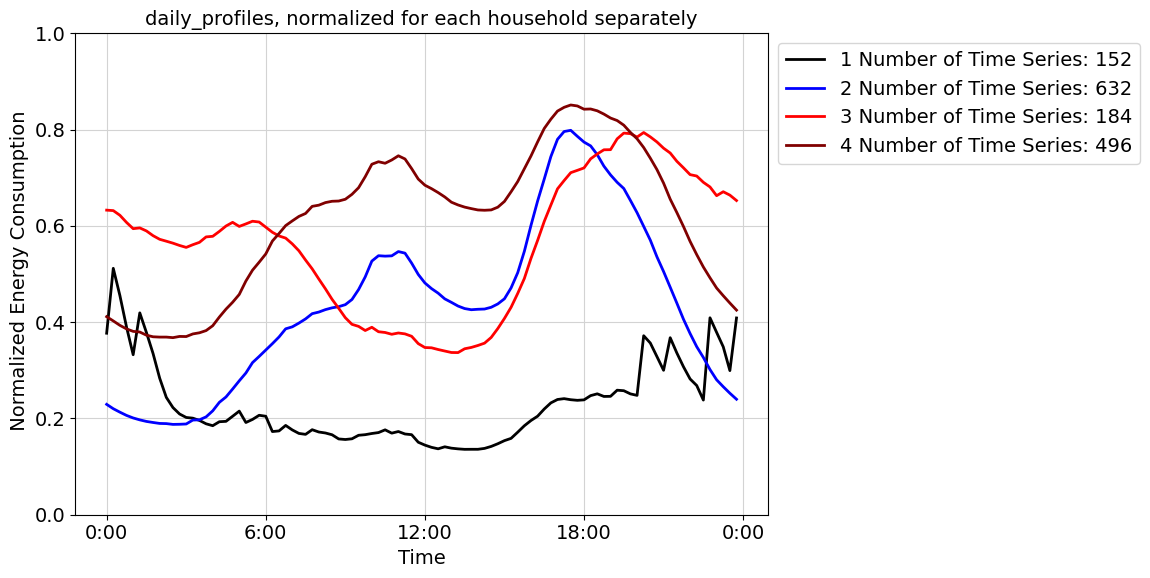

In [158]:
to_save = 0 #if you want to save the plots save=1

plot_clusters_season(to_save)

plt.rcParams['font.size'] = 14

### Plotting the clusters in separate plots

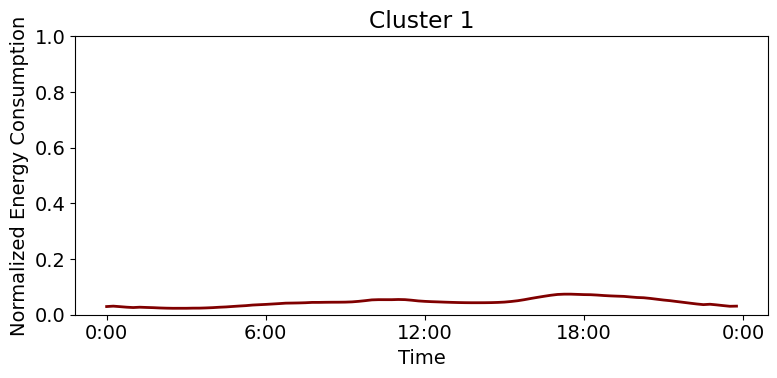

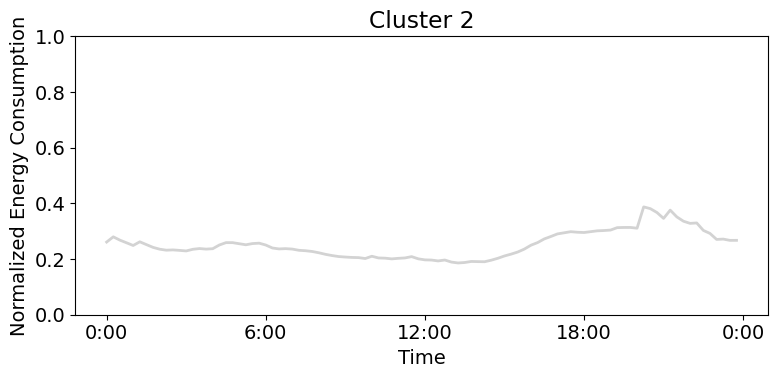

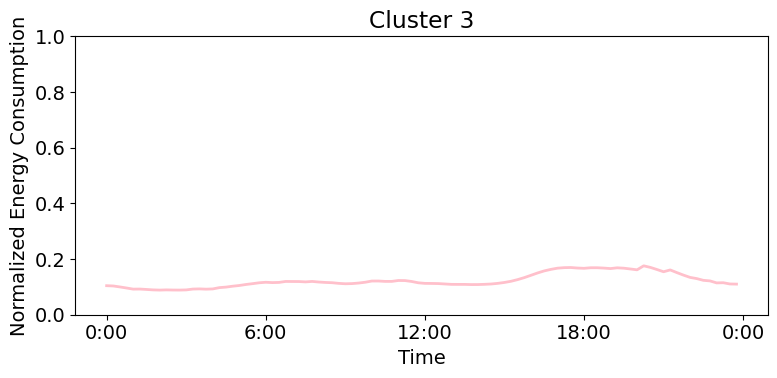

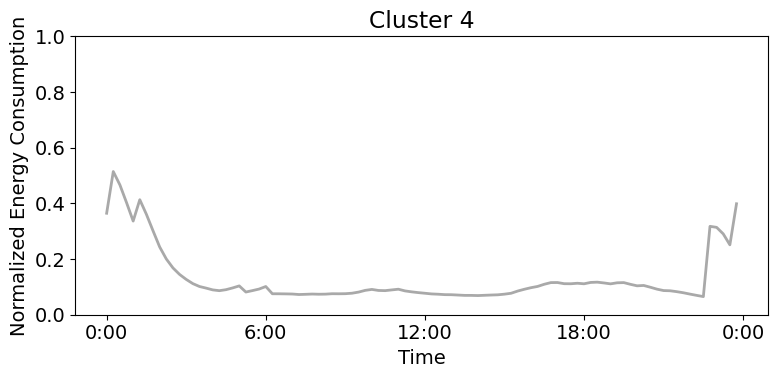

In [146]:
# Calculate and plot the average pattern for each cluster
save = 0 #if you want to save the plots

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','darkslategrey','turquoise','magenta','pink','violet']

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1,97), mean_time_series.ravel()[:96], 
             label= f'Mean Time Series \n No. of Time Series: {len(cluster_indices)}',
               linewidth =2, color= colors[cluster_idx] )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


### Plotting Mean, Median and percentiles of the clusters

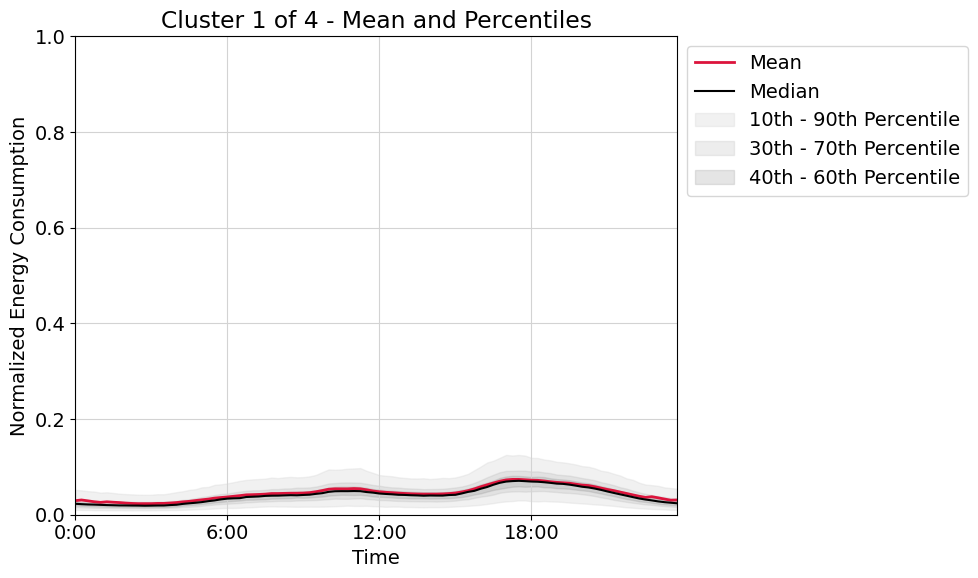

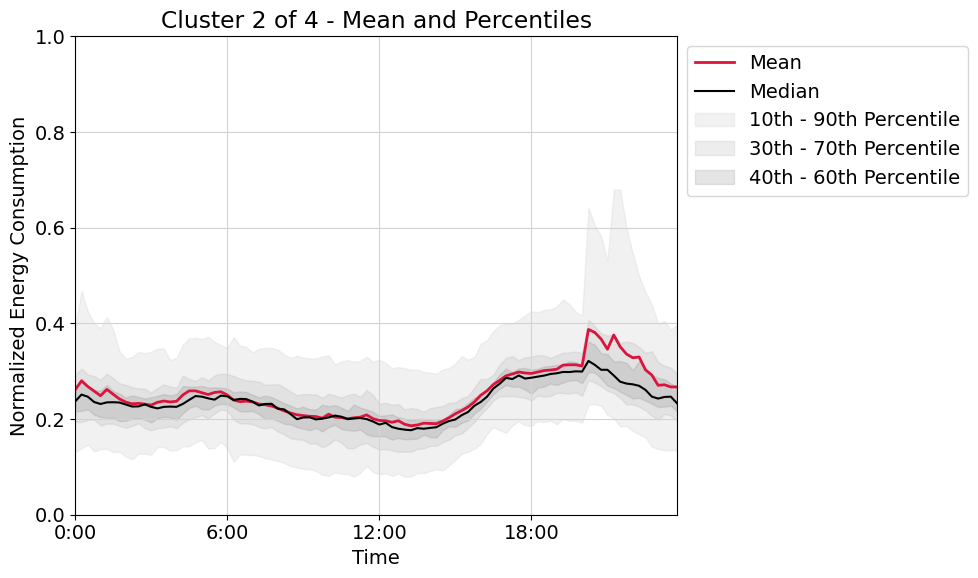

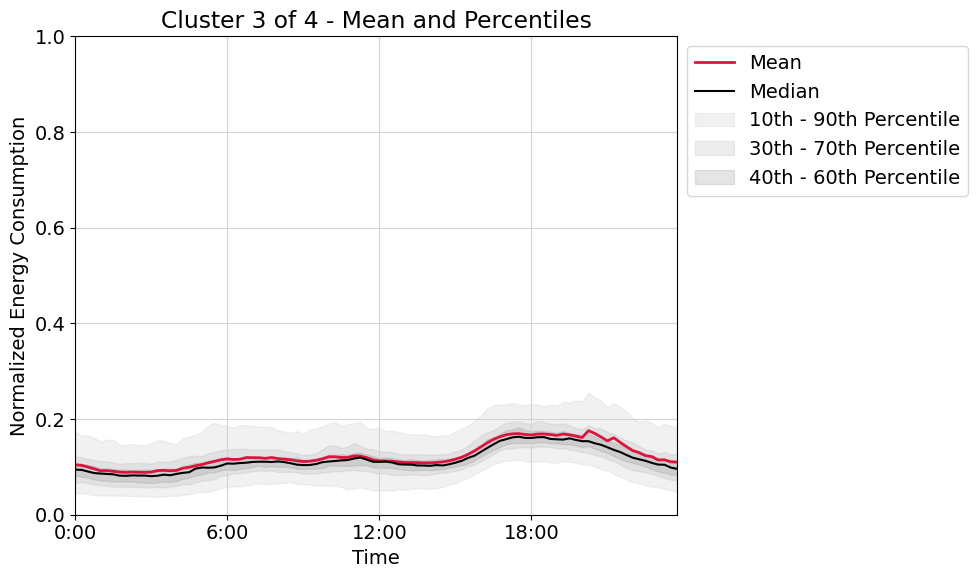

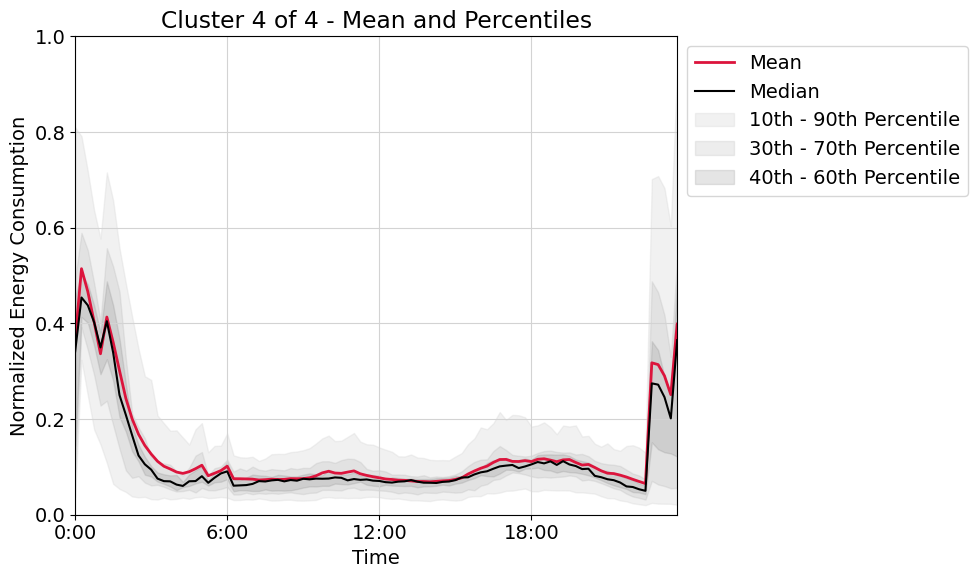

shape: (96, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ lower_perc ┆ lower_perc ┆ lower_perc ┆ lower_per ┆ upper_per ┆ upper_per ┆ upper_per ┆ upper_per │
│ entile_clu ┆ entile_clu ┆ entile_clu ┆ centile_c ┆ centile_c ┆ centile_c ┆ centile_c ┆ centile_c │
│ ster_1     ┆ ster_2     ┆ ster_3     ┆ luster_4  ┆ luster_1  ┆ luster_2  ┆ luster_3  ┆ luster_4  │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.010119   ┆ 0.131339   ┆ 0.045531   ┆ 0.037186  ┆ 0.051998  ┆ 0.389284  ┆ 0.174257  ┆ 0.809922  │
│ 0.009959   ┆ 0.138388   ┆ 0.045083   ┆ 0.32361   ┆ 0.050952  ┆ 0.467534  ┆ 0.165328  ┆ 0.791258  │
│ 0.009849   ┆ 0.14654    ┆ 0.043209   ┆ 0.249484  ┆ 0.049309  ┆ 0.424766  ┆

In [147]:
plt.rcParams['font.size'] = 14

save = 0
save_file = 0
lower_percentile = 10
median_percentile = 50
upper_percentile = 90

# Percentiles to be used for shading
lower_shade_percentile = 30
mid_shade_percentile = 40
upper_shade_percentile = 70
top_shade_percentile = 60

# Initialize lists to store percentile data for each cluster
lower_percentile_columns = []
upper_percentile_columns = []

# Assuming train_weekdays and clusters_train are defined and n_clusters is set
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    
    # Calculate the mean and percentiles for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    median_time_series = np.median(cluster_data, axis=0)
    lower_percentile_series = np.percentile(cluster_data, lower_percentile, axis=0)
    median_percentile_series = np.percentile(cluster_data, median_percentile, axis=0)
    
    lower_shade_series = np.percentile(cluster_data, lower_shade_percentile, axis=0)
    mid_shade_series = np.percentile(cluster_data, mid_shade_percentile, axis=0)
    top_shade_series = np.percentile(cluster_data, top_shade_percentile, axis=0)
    upper_shade_series = np.percentile(cluster_data, upper_shade_percentile, axis=0)
    
    upper_percentile_series = np.percentile(cluster_data, upper_percentile, axis=0)

    # Convert to flat arrays if needed
    lower_percentile_series = np.ravel(lower_percentile_series)
    upper_percentile_series = np.ravel(upper_percentile_series)
    lower_shade_series = np.ravel(lower_shade_series)
    mid_shade_series = np.ravel(mid_shade_series)
    top_shade_series = np.ravel(top_shade_series)
    upper_shade_series = np.ravel(upper_shade_series)

    # Store results in lists
    lower_percentile_columns.append(pl.Series(f'lower_percentile_cluster_{cluster_idx+1}', lower_percentile_series))
    upper_percentile_columns.append(pl.Series(f'upper_percentile_cluster_{cluster_idx+1}', upper_percentile_series))
    
    # Plot the mean and percentile bands
    plt.figure(figsize=(10, 6))
    plt.grid( color='lightgray')
    plt.plot(range(1, 97), mean_time_series, label='Mean', color='crimson', linewidth=2)
    plt.plot(range(1, 97), median_time_series, label='Median', color='black', linewidth=1.5)
    
    # Fill between percentiles for shading
    plt.fill_between(range(1, 97), lower_percentile_series, upper_percentile_series, color='lightgray', alpha=0.3, label=f'{lower_percentile}th - {upper_percentile}th Percentile')
    plt.fill_between(range(1, 97), lower_shade_series, upper_shade_series, color='darkgray', alpha=0.2, label=f'{lower_shade_percentile}th - {upper_shade_percentile}th Percentile')
    plt.fill_between(range(1, 97), mid_shade_series, top_shade_series, color='gray', alpha=0.2, label=f'{mid_shade_percentile}th - {top_shade_percentile}th Percentile')
    
    plt.title(f"Cluster {cluster_idx + 1} of {n_clusters} - Mean and Percentiles")
    plt.xlabel("Time", fontsize = 14)
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0, 1)
    plt.yticks(fontsize = 14)
    plt.xticks(range(1, 120, 24), labels=['0:00', '6:00', '12:00', '18:00', '0:00'], fontsize = 14)
    plt.margins(0)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
plt.show()

# Combine results into a Polars DataFrame
cluster_percentiles_df = pl.DataFrame(lower_percentile_columns + upper_percentile_columns)
print(cluster_percentiles_df)